### Negative log-likelihood plots

In [2]:
from I3Tray import *
from icecube import icetray, dataclasses, phys_services, sim_services, dataio,  earthmodel_service, neutrino_generator, tableio, hdfwriter
from icecube.simprod import segments
from icecube.icetray import I3Units, I3Frame
from icecube.dataclasses import I3Particle
from icecube.simclasses import I3MMCTrack
from icecube.icetray import I3Units, OMKey, I3Frame
import numpy as np
from matplotlib import pyplot as plt
from Reconstruction.llh.reco_pdfs import cpandel as pdf
import numpy as np
import sys, os
import math
from os import path
from scipy import stats
from scipy.stats import norm
import random as rand
import scipy.special as sp
from scipy import optimize as op
import time

In [3]:
def frame_absent(run_num):
    if (run_num==6 or run_num==14 or run_num==36 or run_num==41 or run_num==49 or run_num==54 or run_num==59 or run_num==61 or run_num==76 or run_num==80 or run_num==82 or run_num==106 or run_num==131 or run_num==133 
        or run_num==129 or run_num==140 or run_num==149 or run_num==155 or run_num==172 or run_num==176 or run_num==147 or run_num==189 or run_num==193 or run_num==198 or run_num==208 or run_num==214 or run_num==216
        or run_num==223 or run_num==235 or run_num==238 or run_num==252 or run_num==284 or run_num==288 or run_num==311 or run_num==369 or run_num==371 or run_num==377 or run_num==379 or run_num==378 or run_num==385 or run_num==389 or run_num==390 
        or run_num==391 or run_num==392 or run_num==393 or run_num==397 or run_num==594
        or run_num==395 or run_num==399 or run_num==401 or run_num==403 or run_num==419 or run_num==471 or run_num==521 or run_num==522 or run_num==550 or run_num==538 or run_num==574 or 
        run_num==584 or run_num==569 or run_num==643 or run_num==646 or run_num==647 or run_num==648 
        or run_num==650 or run_num==656 or run_num==657
        or run_num==658 or run_num==659 or run_num==665 or run_num==675 or run_num==683 or run_num==685 or run_num==686 or run_num==708 or run_num==711
        or run_num==714 or run_num==726 or run_num==737 or run_num==835 or run_num==873 or run_num==889 or run_num==746 or run_num==837 or run_num==867 or run_num==878 or run_num==917 or run_num==944 or run_num==949 or run_num==954 or run_num==963 or run_num==971
        or run_num==972 or run_num==895 or run_num==984 or run_num==987 or run_num==988 or run_num==989):
        return True
    else:
        return False

In [4]:
def GetGeoTime(position,vert) :
    c = 0.299792458                                 # speed of light 
    n = 1.34
    ngroup = 1.35557                                # 1.33 is the refractive index of water at 20 degrees C
    c_n = c/ngroup                                     # light in water
    x = position.x - vert.x
    y = position.y - vert.y
    z = position.z - vert.z
    dc = np.sqrt(x*x + y*y + z*z)
    t = dc/c_n
    return dc,t

In [5]:
def anisotropy(position,vert,direction):
    k=1.5
    amp=1251.1

    x1=-(vert.x-position.x)
    y1=-(vert.y-position.y)
    z1=-(vert.z-position.z)
    r1= math.sqrt(x1*x1+y1*y1+z1*z1)

    x2= direction.x
    y2= direction.y
    z2= direction.z         
    zeta=np.arccos((x1*x2+y1*y2+z1*z2)/r1)    
    weight= amp*((np.exp(k*np.cos(zeta))*(np.sin(zeta)))*(k/(2*np.sinh(k))))

    return weight

In [6]:
def GetVertexTime(pulse_series,geo_doms):
    
    c = 0.299792458                                 # speed of light
    n = 1.34
    ngroup = 1.35557                                # 1.33 is the refractive index of water at 20 degrees C
    c_n= c/ngroup                                     # light in water
    ismc = False
    if(type(pulse_series) == 'icecube.dataclasses.I3RecoPulseSeriesMap') :
        ismc = True

    totalcharge = 0.0
    vx = 0.0
    vy = 0.0
    vz = 0.0

    for domkey in pulse_series.keys() :
        domkey_nopmt =  OMKey(domkey.string, domkey.om, 0)
        for pulse in pulse_series[domkey] :
            totalcharge += pulse.charge     
            vx += geo_doms[domkey_nopmt].position.x*pulse.charge
            vy += geo_doms[domkey_nopmt].position.y*pulse.charge
            vz += geo_doms[domkey_nopmt].position.z*pulse.charge

    vertex = dataclasses.I3Position(vx/totalcharge,vy/totalcharge,vz/totalcharge)
    
    #print("GetVertexTime:",vertex)

    T0 = 0.0

    for domkey in pulse_series.keys() :
        domkey_nopmt =  OMKey(domkey.string, domkey.om, 0)
        for pulse in pulse_series[domkey] :
            dx = vertex.x - geo_doms[domkey_nopmt].position.x
            dy = vertex.y - geo_doms[domkey_nopmt].position.y
            dz = vertex.z - geo_doms[domkey_nopmt].position.z
            dist = np.sqrt(dx*dx+dy*dy+dz*dz)
            T0 += pulse.time - dist/c_n

    T0 /= totalcharge
    T0 -= 5.0
    return T0, vertex

In [7]:
def LikelihoodFunctor(data,domsUsed):
    
    pulse_series = data
    geo_doms = domsUsed
    c = 0.299792458                                 # speed of light
    n = 1.34
    ngroup = 1.35557                                # 1.33 is the refractive index of water at 20 degrees C
    c_n = c/ngroup                                     # light in water
    lambda_s = 120.                                 # scattering length of light for violet light
    lambda_a = 15.                                  # absorption length of light for violet light
    tau = 18.949132224466762                        # time parameter that has to be fit using simulations or data

    
    # uses the prior defined functions to build a likelihood function that when given a track (linefit) will produce a negative loglikelihood value
    def likelihoodFunction(vert_x, vert_y, vert_z, theta, phi, t0):

        dark = 1.e-15
        vertex = dataclasses.I3Position(vert_x, vert_y, vert_z)
        direction = dataclasses.I3Direction(np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta))  
    
        sum_nloglike = 0.0
        for dom in pulse_series.keys() :
            domkey =  OMKey(dom.string, dom.om, 0)
            dc,t = GetGeoTime(geo_doms[domkey].position,vertex)
            p_charge = np.exp(-dc/tau)/max(dc,0.25)
            
            for pulse in pulse_series[dom] :
                charge = 1.0
                cpandel_out = pdf(pulse.time - t0 - t ,dc)
                if(type(pulse_series) == 'icecube.dataclasses.I3RecoPulseSeriesMap') :
                    charge = pulse.charge                
                
                sum_nloglike -= charge*np.log(cpandel_out*p_charge+dark*anisotropy(geo_doms[domkey].position,vertex,direction)+dark)
                sum_nloglike -= charge*min(0.0,pulse.time - t0 - t)
                
        return sum_nloglike
    
    return likelihoodFunction

In [28]:
gcd = dataio.I3File('/home/users/kaustav/pone_offline/GCD/PONE_Phase1.i3.gz') #GCD file for the position of DOMs
frame_geodoms=gcd.pop_frame()
domsUsed=frame_geodoms['I3Geometry'].omgeo
nfitparameters_llhfit=5
nfitparameters_nutau=4
radius_nllh=np.zeros(550)
R_truth=0
events=0

for i in range(0,50):
    print("file:",i)
    if path.exists("/data/p-one/kdutta/Neutau_anisotropy/Nu_reco"+str(i)+".i3.zst")==True:
        infile_name="/data/p-one/kdutta/Neutau_anisotropy/Nu_reco"+str(i)+".i3.zst"
        if(frame_absent(i)==False):
            infile=dataio.I3File(infile_name)
            infile.pop_frame()
            infile.pop_frame()
            for frame in infile:
                events=events+1
                if(frame['NuGPrimary'].pdg_encoding==12 or frame['NuGPrimary'].pdg_encoding==-12 or frame['NuGPrimary'].pdg_encoding==16 or frame['NuGPrimary'].pdg_encoding==-16):
                    pulses=0
                    pulseseriesmap=frame['I3Photons_PMTResponse']
                    for omkey in pulseseriesmap.keys():
                        for pulse in pulseseriesmap[omkey]:
                            pulses=pulses+1

                    data = frame['I3Photons_PMTResponse']
                    MMCTrackList=frame['MMCTrackList']
                    secondary=MMCTrackList[0].GetI3Particle()
                    qFunctor = LikelihoodFunctor(data,domsUsed)
                    direction = secondary.dir
                    T0=secondary.time-frame['TimeShiftedMCPEMap_toffset'].value
                    x=secondary.pos.x
                    y=secondary.pos.y
                    z=secondary.pos.z
                    R_truth=math.sqrt(secondary.pos.x**2+secondary.pos.y**2+secondary.pos.z**2)
                
                    for vertexRad in range(0,550):
                        def func(x):
                            vert_x, vert_y, vert_z, theta, phi, t0 = x
                            return qFunctor(vert_x, vert_y, vert_z, theta, phi, t0)
                        solution=func(np.array([x,y,z,direction.theta,direction.phi,T0]))/(pulses-nfitparameters_nutau)
                        radius_nllh[vertexRad]=radius_nllh[vertexRad]+solution
                
for i in range(0,len(radius_nllh)):
    radius_nllh[i]=radius_nllh[i]/events

file: 0
file: 1
file: 2
file: 3
file: 4
file: 5
file: 6
file: 7
file: 8
file: 9
file: 10
file: 11
file: 12
file: 13
file: 14
file: 15
file: 16
file: 17
file: 18
file: 19
file: 20
file: 21
file: 22
file: 23
file: 24
file: 25
file: 26
file: 27
file: 28
file: 29
file: 30
file: 31
file: 32
file: 33
file: 34
file: 35
file: 36
file: 37
file: 38
file: 39
file: 40
file: 41
file: 42
file: 43
file: 44
file: 45
file: 46
file: 47
file: 48
file: 49


In [29]:
print(radius_nllh)

[16.58532613 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613
 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613
 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613
 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613
 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613
 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613
 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613
 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613
 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613
 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613
 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613
 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613
 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613 16.58532613
 16.58532613 16.58532613 16.58532613 16.58532613 16

In [23]:
print(events)

121


In [30]:
print("What we have:",np.where(radius_nllh==np.min(radius_nllh))[0][0])
print("What we need:",R_truth)

What we have: 0
What we need: 340.5191005917214


In [88]:
print("VTheta:",VTheta)
print("VPhi:",VPhi)
print("theta:",direction.theta)
print("phi:",direction.phi)

VTheta: 0.9901765297492193
VPhi: 3.603785256134071
theta: 1.7179125585542434
phi: 0.2381583486629255


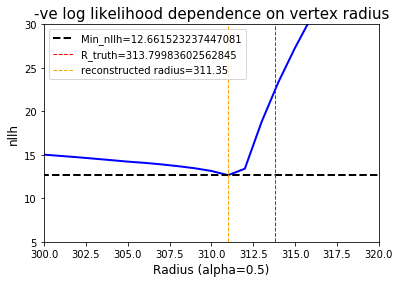

In [89]:
radius=np.arange(0,550)
plt.plot(radius,radius_nllh,color='blue',linewidth=2)
x=[0,550]
y=[np.min(radius_nllh),np.min(radius_nllh)]
y1=[0,800]
x1=[R_truth,R_truth]
y2=[0,800]
x2=[np.where(radius_nllh==np.min(radius_nllh))[0][0],np.where(radius_nllh==np.min(radius_nllh))[0][0]]
plt.plot(x,y,linewidth=2,linestyle='dashed',color='black', label="Min_nllh="+str(np.min(radius_nllh)))
plt.plot(x1,y1,linewidth=1,linestyle='dashed',color='red', label="R_truth="+str(R_truth))
plt.plot(x2,y2,linewidth=1,linestyle='dashed',color='orange',label="reconstructed radius="+str(311.35))

plt.xlabel("Radius (alpha=0.5)",fontsize=12)
plt.ylabel("nllh",fontsize=12)
plt.title("-ve log likelihood dependence on vertex radius",fontsize=15)
plt.legend(loc="upper left") #bbox_to_anchor=(0.5, -0.4))
plt.xlim(300,320)
plt.ylim(5,30)
plt.show()

## HeatMaps...

In [41]:
gcd = dataio.I3File('/home/users/kaustav/pone_offline/GCD/PONE_Phase1.i3.gz') #GCD file for the position of DOMs
frame_geodoms=gcd.pop_frame()
domsUsed=frame_geodoms['I3Geometry'].omgeo
nfitparameters_llhfit=5
nfitparameters_nutau=4
vertexRad=313.7998360
nllh=np.zeros(shape=[18,18])


for i in range(0,1):
    if path.exists("/data/p-one/kdutta/Neutau_anisotropy/Nu_reco"+str(i)+".i3.zst")==True:
        infile_name="/data/p-one/kdutta/Neutau_anisotropy/Nu_reco"+str(i)+".i3.zst"
        if(frame_absent(i)==False):
            infile=dataio.I3File(infile_name)
            infile.pop_frame()
            infile.pop_frame()
            count=0

            for frame in infile:
                if(frame['NuGPrimary'].pdg_encoding==12 or frame['NuGPrimary'].pdg_encoding==-12 or frame['NuGPrimary'].pdg_encoding==16 or frame['NuGPrimary'].pdg_encoding==-16):
                    print("Energy:",frame['NuGPrimary'].energy)
                    pulses=0
                    pulseseriesmap=frame['I3Photons_PMTResponse']
                    for omkey in pulseseriesmap.keys():
                        for pulse in pulseseriesmap[omkey]:
                            pulses=pulses+1
        
                    data = frame['I3Photons_PMTResponse']
                    MMCTrackList=frame['MMCTrackList']
                    secondary=MMCTrackList[0].GetI3Particle()
                    qFunctor = LikelihoodFunctor(data,domsUsed)
                    direction = secondary.dir
                    T0=secondary.time-frame['TimeShiftedMCPEMap_toffset'].value
                    x=secondary.pos.x
                    y=secondary.pos.y
                    z=secondary.pos.z
                    row=-1
                    for Phi in range(0, 360, 20):
                        row=row+1
                        col=-1
                        for Theta in range(0, 180, 10):
                            col=col+1
                            theta=(Theta/180)*np.pi
                            phi=(Phi/180)*np.pi
                            def func(x):
                                vert_x, vert_y, vert_z, theta, phi, t0 = x
                                return qFunctor(vert_x, vert_y, vert_z, theta, phi, t0)
                            solution=func(np.array([x,y,z,theta,phi,T0]))/(pulses-nfitparameters_nutau)         
                            print(solution)
                            if(solution<min_nllh):
                                min_nllh=solution
                                min_theta=theta
                                min_phi=phi
                           
                            nllh[row][col]=solution
            

                    break

Energy: 3095.3312855321274
24.78719104359741
24.781449076934628
24.776185923867473
24.771744181494427
24.76844198702882
24.766485269469296
24.765778876636073
24.765672230382172
24.76531697791867
24.76493248067815
24.765326514672864
24.765910136527467
24.765370280797793
24.76550371996597
24.767134104472916
24.770211498055524
24.774447216553394
24.77948377511829
24.78719104359741
24.78024359204948
24.773929004636678
24.768512475290247
24.764223897921408
24.761216172069236
24.75952595011382
24.759063641022074
24.759637370494495
24.760978142368653
24.76269911880019
24.763789916689078
24.76338583251066
24.763379781205934
24.76488625324836
24.76804968573115
24.77266736322236
24.778426845149717
24.78719104359741
24.779895764196237
24.773389881714408
24.767932260986363
24.763814260207027
24.76136254982845
24.760926385088915
24.76278776855683
24.76674987290314
24.770843520908898
24.771212126804976
24.768245595883815
24.76543784462649
24.764311444809827
24.765172558794575
24.76794214195691
24.77

In [23]:
print(direction.theta)
print(direction.phi)

1.7179125585542434
0.2381583486629255


In [24]:
print(min_nllh,min_theta,min_phi)

24.759063641022074 1.2217304763960306 0.3490658503988659


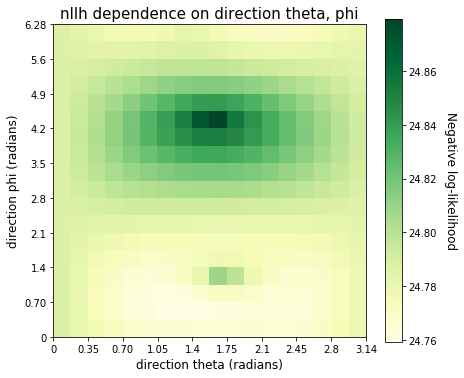

In [40]:
fig, ax = plt.subplots(figsize =(7, 7))
plt.imshow(nllh, cmap='YlGn',origin='lower')
plt.title("nllh dependence on direction theta, phi",fontsize=15)

positions_x = (-0.5,1.5,3.5,5.5,7.5,9.5,11.5,13.5,15.5,17.5)
positions_y= (-0.5,1.5,3.5,5.5,7.5,9.5,11.5,13.5,15.5,17.5)
labels_x = ("0","0.70","1.4","2.1","2.8","3.5","4.2","4.9","5.6","6.28")
labels_y=("0","0.35","0.70","1.05","1.4","1.75","2.1","2.45","2.8","3.14")
plt.xticks(positions_y, labels_y)
plt.yticks(positions_x, labels_x)


ax.set_ylabel('direction phi (radians)',fontsize=12) 
ax.set_xlabel('direction theta (radians)',fontsize=12) 
cbar=plt.colorbar(shrink=0.85)
cbar.ax.get_yaxis().labelpad = 20
cbar.set_label('Negative log-likelihood', rotation=270, fontsize=12)
plt.show()